# Bayesian Linear Regression - Adaptive coefficients
This post follows on from looking at [Bayesian Linear Regression](https://www.richard-stanton.com/2021/06/07/sequential-bayesian-regression.html).
Here we look at the ability of the above method to track non-stationary problems where the regression coefficients can vary with time.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

## Generate some dummy data
We generate regression data where the underlying weights vary with time.

In [2]:
n = 10000
m = 2
np.random.seed(3)

noise_std = 2

x = np.random.uniform(-1, 1, size=(n, m))
x = np.hstack([np.ones(shape=(n, 1)), x])

w_bias = np.random.uniform(-1, 1, size=(1, m + 1))
w_line = 2 * np.append(0, np.random.uniform(-1, 1, size=(1, m)))

t = np.linspace(0, 1, n)[:, np.newaxis]

w = (t * w_line) + w_bias

y_true = (x * w).sum(axis=1)
y = y_true + np.random.normal(loc=0, scale=noise_std, size=n)

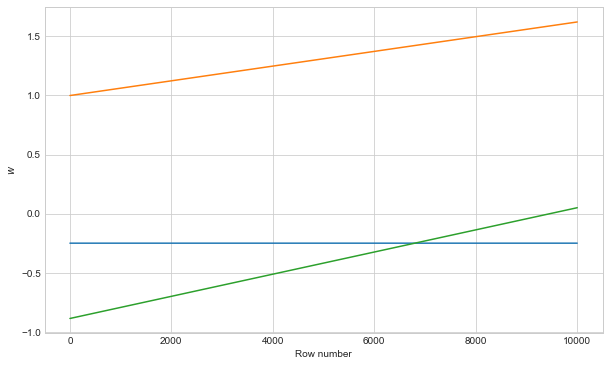

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w)
ax.set_ylabel("$w$")
ax.set_xlabel("Row number")
plt.show()

## Fit a linear regression with `statsmodels`
We fit a standard linear regression model with `statsmodels`:

In [4]:
results = sm.OLS(y, x).fit()
print(results.summary())
print("\n")
print(f"Avg w: {w.mean(axis=0)}")

# extract coefficient distributions
w_sm_mu = results.params
w_sm_std = np.sqrt(np.diag(results.normalized_cov_params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     823.6
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:09:31   Log-Likelihood:                -21058.
No. Observations:               10000   AIC:                         4.212e+04
Df Residuals:                    9997   BIC:                         4.214e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2503      0.020    -12.593      0.0

Fitting a standard linear regression model will take the average coefficient over all our data.
The standard deviation of those coefficients will be larger than stationary coefficients to reflect the increased error.
In the following the blue lines are the fitted coefficients and the red region is the coefficient standard deviation.

ipykernel_launcher:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


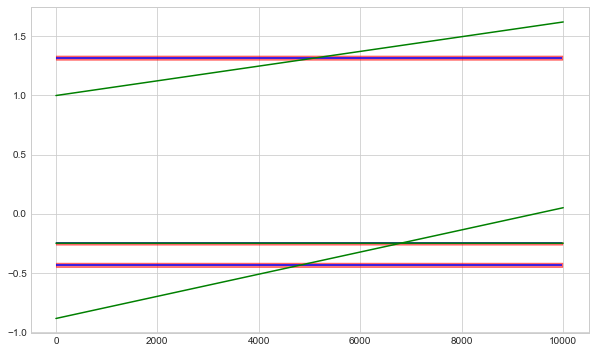

In [5]:
start_skip = 20

fig, ax = plt.subplots(figsize=(10, 6))

for idx in range(m + 1):
    ax.hlines(w_sm_mu[idx], 0, n - start_skip,color='b', label='SeqBayes')
    ax.fill_between(
        np.arange(n - start_skip),
        (w_sm_mu - w_sm_std)[idx],
        (w_sm_mu + w_sm_std)[idx],
        alpha=0.5,
        color='r'
    )

ax.plot(w, color='g', label='Actual')

fig.show()

## Sequential bayesian regression
As previously seen we can fit the same problem with a bayesian sequentially updating method.
Updating some prior distibution over our coefficients to get a posterior.

In [6]:
class BayesLinearRegressor:
    def __init__(
        self, number_of_features, mean=None, cov=None, alpha=1e6, beta=1
    ):
        # prior distribution on weights
        if mean is None:
            self.mean = np.array([[0] * (number_of_features)], dtype=float).T

        if cov is None:
            self.cov = alpha * np.identity(number_of_features)
            self.cov_inv = np.linalg.inv(self.cov)
            self.cov_init = self.cov

        self.beta = beta  # process noise
        self.number_of_features = number_of_features

    def fit(self, x, y):
        return self.update(x, y)

    def update(self, x, y, inc_alpha=None):
        """
        Perform a bayesian update step
        """
        if len(x.shape) == 1:
            x = x[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[:, np.newaxis]

        # update state of covariance and means
        cov_n_inv = self.cov_inv + self.beta * x.T @ x
        cov_n = np.linalg.inv(cov_n_inv)
        mean_n = cov_n @ (self.cov_inv @ self.mean + self.beta * x.T @ y)

        if inc_alpha is not None:
            # cov_n = cov_n - (cov_n - self.cov_init) * inc_alpha
            cov_n = cov_n + inc_alpha * np.identity(self.number_of_features)

            cov_n_inv = np.linalg.inv(cov_n)

        self.cov_inv = cov_n_inv
        self.cov = cov_n
        self.mean = mean_n

    def predict(self, x):
        mean = x @ self.mean
        scale = np.sqrt(np.sum(x @ self.cov @ x.T, axis=1))
        return mean, scale

    @property
    def coef_(self):
        return self.mean

    @property
    def scale_(self):
        return np.sqrt(np.diag(self.cov))

### Sequential training
We will train the model with one data point at a time.

In [7]:
bayes_linear_regression = BayesLinearRegressor(x.shape[1])

params_mu_seq = []
params_std_seq = []
for idx in range(n):
    bayes_linear_regression.update(
        x[idx, :],
        y[[idx]],
    )

    params_mu_seq.append(bayes_linear_regression.coef_.flatten())
    params_std_seq.append(bayes_linear_regression.scale_)

params_mu_seq = pd.DataFrame(params_mu_seq)
params_std_seq = pd.DataFrame(params_std_seq)

Now lets plot the results.
We skip the first few samples as the coefficients will be pretty wild and large at the start.

ipykernel_launcher:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


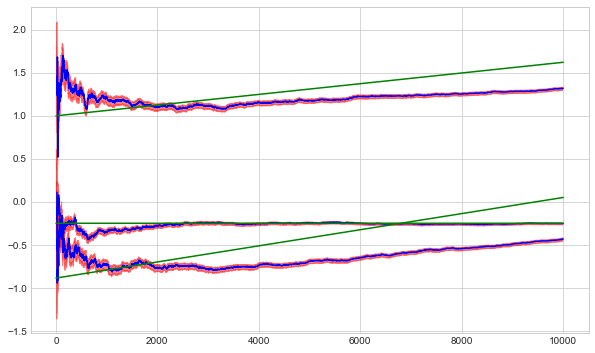

In [8]:
def plot_seq_results(params_mu, params_std, start_skip = 20):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(params_mu.iloc[start_skip:, :], color='b', label='SeqBayes')

    for idx in range(m + 1):
        ax.fill_between(
            np.arange(n - start_skip),
            (params_mu - params_std).iloc[start_skip:, idx],
            (params_mu + params_std).iloc[start_skip:, idx],
            alpha=0.5,
            color='r'
        )
    if 1:
        ax.plot(w, color='g', label='Actual')

    if 0:
        w_sm_mu
        w_sm_std
    # fig.legend()
    fig.show()

plot_seq_results(params_mu_seq, params_std_seq)

The coefficients do drift in the correct direction with row number,
but they don't move enough to keep up with the underlying change.
The standard deviation of the coefficients shrink as we have seen before when we introduce more data.
The coefficients actually converge identically to the coefficients of the `statsmodels` approach,
towards the average coefficient.

### Changing the adaptive rate
In this problem we are trying to update our distributions to a moving target...
Therefore we need to do something different to track the moving coefficients.
We can do that at each training iteration by inflating the distribution standard deviation a bit each time.
This makes the model less certain about it's current estimate and allows it to higher weight
new data when producing the posterior distributions.
That is achieved by adding to the diagonal of the model covariance matrix.
This is done in the above class with the following line:
```
cov_n = cov_n + inc_alpha * np.identity(self.number_of_features)
```
By adding a small amount we can see the coefficient respond faster to changes.
There is a slightly larger standard deviation observed for the coefficients and they track the varying coefficients more closely than before.

In [9]:
bayes_linear_regression = BayesLinearRegressor(x.shape[1], beta=1)

params_mu_seq = []
params_std_seq = []
for idx in range(n):
    bayes_linear_regression.update(
        x[idx, :],
        y[[idx]],
        inc_alpha=5e-6,
    )

    params_mu_seq.append(bayes_linear_regression.coef_.flatten())
    params_std_seq.append(bayes_linear_regression.scale_)

params_mu_seq = pd.DataFrame(params_mu_seq)
params_std_seq = pd.DataFrame(params_std_seq)

plot_seq_results(params_mu_seq, params_std_seq)

ipykernel_launcher:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


### Step changes
We can repeat the same challenge with a step change to see how the model can adapt.
With the following we put a step change in the coefficients half way along the data.

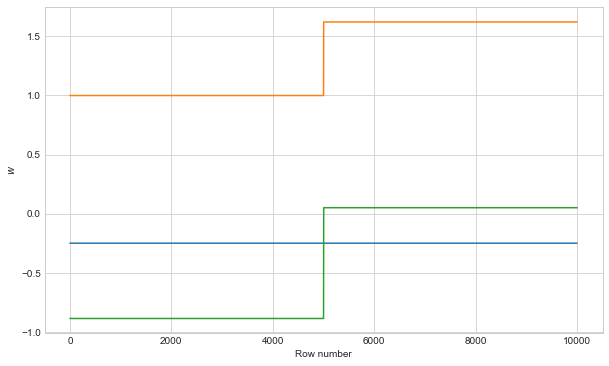

In [10]:
n = 10000
m = 2
np.random.seed(3)

noise_std = 2

x = np.random.uniform(-1, 1, size=(n, m))
x = np.hstack([np.ones(shape=(n, 1)), x])

w_bias = np.random.uniform(-1, 1, size=(1, m + 1))
w_line = 2 * np.append(0, np.random.uniform(-1, 1, size=(1, m)))

t = np.linspace(0, 1, n)[:, np.newaxis]

w = ((t>0.5) * w_line) + w_bias

y_true = (x * w).sum(axis=1)
y = y_true + np.random.normal(loc=0, scale=noise_std, size=n)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w)
ax.set_ylabel("$w$")
ax.set_xlabel("Row number")
plt.show()

We can see the model coefficients respond to the step change.
As before - we can vary the `inc_alpha` parameter to allow the model to adapt faster to changes.

ipykernel_launcher:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


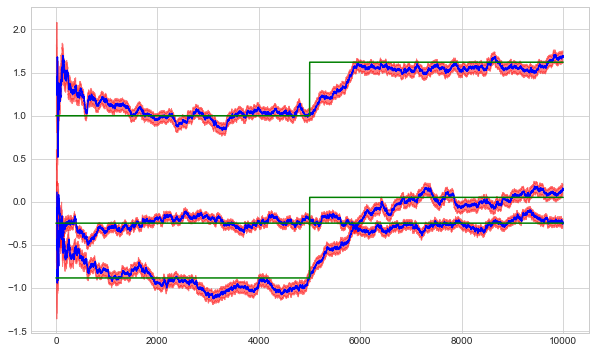

In [11]:
bayes_linear_regression = BayesLinearRegressor(x.shape[1], beta=1)

params_mu_seq = []
params_std_seq = []
for idx in range(n):
    bayes_linear_regression.update(
        x[idx, :],
        y[[idx]],
        inc_alpha=5e-6,
    )

    params_mu_seq.append(bayes_linear_regression.coef_.flatten())
    params_std_seq.append(bayes_linear_regression.scale_)

params_mu_seq = pd.DataFrame(params_mu_seq)
params_std_seq = pd.DataFrame(params_std_seq)

plot_seq_results(params_mu_seq, params_std_seq)